In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

file_path = '../../data/processed/feature_selected_data.parquet'
df = pd.read_parquet(file_path, engine= 'pyarrow')

In [3]:
# questo è un TODO definito nel file feature_selection.py ma ancora non fatto
df.drop(columns=['codice_struttura_erogazione'], inplace=True)

In [4]:
df.columns

Index(['id_prenotazione', 'id_paziente', 'data_nascita', 'sesso',
       'regione_residenza', 'tipologia_servizio', 'descrizione_attivita',
       'data_contatto', 'tipologia_struttura_erogazione',
       'id_professionista_sanitario', 'tipologia_professionista_sanitario',
       'data_erogazione', 'durata_erogazione_sec', 'eta', 'anno',
       'quadrimestre'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460509 entries, 0 to 484290
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   id_prenotazione                     460509 non-null  object             
 1   id_paziente                         460509 non-null  object             
 2   data_nascita                        460509 non-null  datetime64[ns, UTC]
 3   sesso                               460509 non-null  object             
 4   regione_residenza                   460509 non-null  object             
 5   tipologia_servizio                  460509 non-null  object             
 6   descrizione_attivita                460509 non-null  object             
 7   data_contatto                       460509 non-null  object             
 8   tipologia_struttura_erogazione      460509 non-null  object             
 9   id_professionista_sanitario    

In [6]:
cols_grouped = ['anno', 'quadrimestre', 'regione_residenza']

In [7]:
grouped = df.groupby(cols_grouped).size().reset_index(name='num_servizi')

In [8]:
grouped.sort_values(by=['num_servizi'], ascending=True)

,anno,quadrimestre,regione_residenza,num_servizi
19,2019,1,Valle d'aosta,24
40,2019,2,Valle d'aosta,35
12,2019,1,Prov. auton. bolzano,43
313,2022,3,Valle d'aosta,49
10,2019,1,Molise,53
...,...,...,...,...
218,2021,3,Lombardia,5466
197,2021,2,Lombardia,5539
134,2020,3,Lombardia,5724
176,2021,1,Lombardia,6776


In [9]:
df_cols_no_anno = cols_grouped.copy()
df_cols_no_anno.remove('anno')

In [10]:
# Calcolo dell'incremento per ogni quadrimestre
grouped['incremento'] = grouped.groupby(df_cols_no_anno)['num_servizi'].diff()


In [11]:
grouped.sort_values(by=['incremento'], ascending=False)

,anno,quadrimestre,regione_residenza,num_servizi,incremento
155,2020,4,Lombardia,7043,3296.0
92,2020,1,Lombardia,4373,2879.0
176,2021,1,Lombardia,6776,2403.0
153,2020,4,Lazio,5015,2282.0
150,2020,4,Campania,4800,2101.0
...,...,...,...,...,...
79,2019,4,Sicilia,2251,NaN
80,2019,4,Toscana,778,NaN
81,2019,4,Umbria,362,NaN
82,2019,4,Valle d'aosta,57,NaN


In [12]:
mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
grouped[mask].sort_values(by=['anno'])

,anno,quadrimestre,regione_residenza,num_servizi,incremento
79,2019,4,Sicilia,2251,NaN
163,2020,4,Sicilia,4111,1860.0
247,2021,4,Sicilia,2704,-1407.0
331,2022,4,Sicilia,2608,-96.0


In [13]:
# DA NON FARE - Elimino i campioni con incremento nullo, sono quelli del 2019 (primo anno storicizzato)
# grouped = grouped.dropna(subset=['incremento'])

In [14]:

# Calcolo dell'incremento percentuale
grouped['incremento_percentuale'] = grouped['incremento'] / grouped.groupby(df_cols_no_anno)['num_servizi'].shift(1) * 100   # shift(1) per avere il valore precedente

# Calcolo dell'incremento percentuale medio per ogni coppia di quadrimestre e regione_erogazione
incremento_percentuale_medio = grouped.groupby(df_cols_no_anno)['incremento_percentuale'].mean().reset_index()

# Visualizza il risultato
app = incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)
app

,quadrimestre,regione_residenza,incremento_percentuale
12,1,Prov. auton. bolzano,84.708326
9,1,Marche,79.933368
5,1,Friuli venezia giulia,78.182993
19,1,Valle d'aosta,75.250798
8,1,Lombardia,72.722854
...,...,...,...
52,3,Molise,8.191616
45,3,Campania,7.481995
43,3,Basilicata,6.624822
31,2,Molise,3.899685


In [15]:
# Visualizzo l'incremento percentuale anno in anno
mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
grouped[mask]

,anno,quadrimestre,regione_residenza,num_servizi,incremento,incremento_percentuale
79,2019,4,Sicilia,2251,NaN,NaN
163,2020,4,Sicilia,4111,1860.0,82.629942
247,2021,4,Sicilia,2704,-1407.0,-34.225249
331,2022,4,Sicilia,2608,-96.0,-3.550296


In [16]:
# Visualizzo, in un nuovo dataframe, l'incremento percentuale medio per ogni coppia di quadrimestre e regione_residenza
mask = (incremento_percentuale_medio['regione_residenza'] == 'Sicilia') & (incremento_percentuale_medio['quadrimestre'] == 4)
incremento_percentuale_medio[mask]

,quadrimestre,regione_residenza,incremento_percentuale
79,4,Sicilia,14.951466


Per studiare i dati e determinare le soglie appropriate per l'assegnazione delle etichette, puoi seguire alcuni passaggi che ti aiuteranno a comprendere meglio la distribuzione degli incrementi percentuali. Ecco una guida pratica su come fare:

1. Esplora la Distribuzione degli Incrementi Percentuali
Distribuzione: 
- Usa un istogramma o un grafico a densità per visualizzare la distribuzione degli incrementi percentuali.
- Statistica Descrittiva: Calcola metriche come la media, la mediana, i quartili, e la deviazione standard.

2. Identifica Valori Estremi (Outliers)
- Gli outlier possono influenzare significativamente le soglie. Identificare e, se necessario, trattare questi valori può essere utile.
- Puoi usare boxplot o interquartile range (IQR) per individuare gli outlier.

3. Segmentazione basata su Quartili
- I quartili (Q1, Q2, Q3) dividono i dati in quattro parti uguali. Usarli per definire le soglie può aiutarti a segmentare in modo equilibrato.

4. Visualizzazione dei Dati
- Scatter plot: Un grafico scatter può aiutare a vedere la relazione tra l'anno e l'incremento percentuale.
- Boxplot: Un boxplot mostra la distribuzione e può evidenziare outlier e valori medi.

In [17]:
# NB: forse i seguenti grafici sono inutili per il momento, ma li lascio per completezza

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


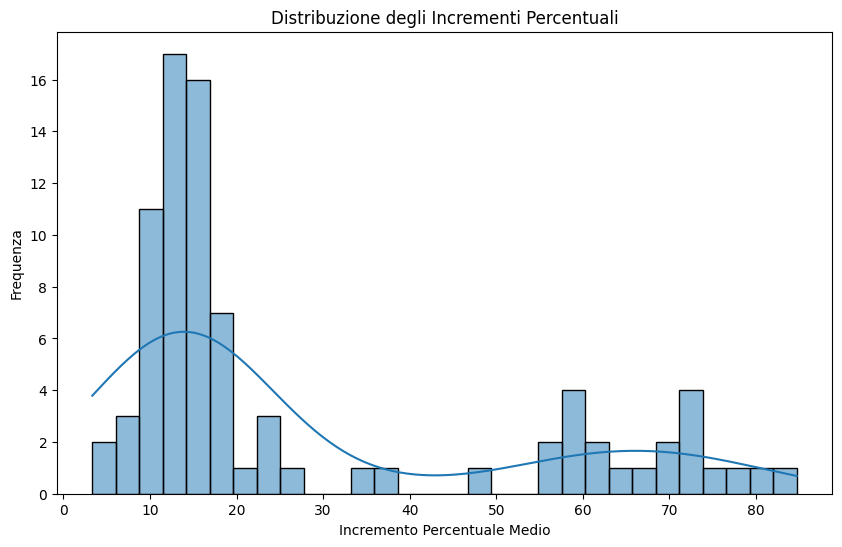

In [19]:
# Calcola la distribuzione degli incrementi percentuali
plt.figure(figsize=(10, 6))
sns.histplot(incremento_percentuale_medio['incremento_percentuale'], bins=30, kde=True)
plt.title('Distribuzione degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale Medio')
plt.ylabel('Frequenza')
plt.show()

In [20]:
# Statistiche descrittive
descr = incremento_percentuale_medio['incremento_percentuale'].describe()
print(descr)

count    84.000000
mean     27.571205
std      23.525024
min       3.325116
25%      12.339706
50%      15.330966
75%      40.512606
max      84.708326
Name: incremento_percentuale, dtype: float64


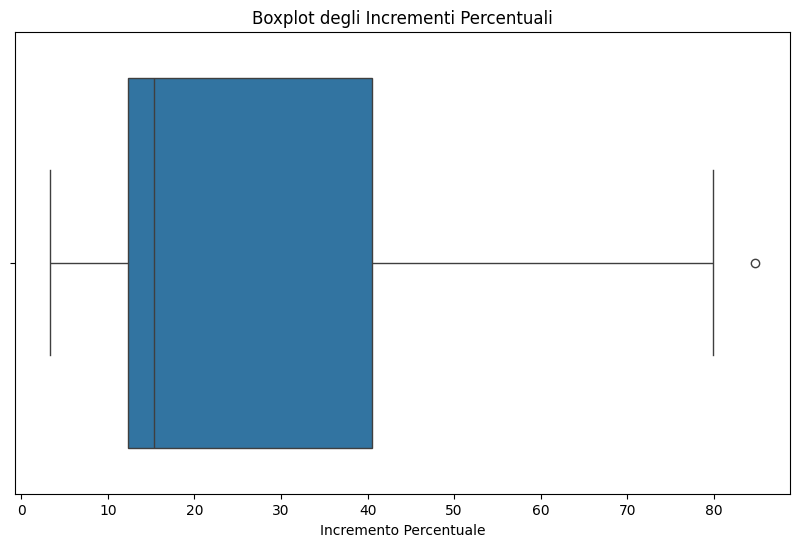

In [21]:
# Boxplot per identificare outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=incremento_percentuale_medio['incremento_percentuale'])
plt.title('Boxplot degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale')
plt.show()

In [22]:
# TODO: dobbiamo identificare anche il decremento?
    # IGNAZIO: si, ci possono essere degli incrementi percentuali medi negativi. Già verificato :(

def classify_increment(value):
    constat_increment = 5 
    low_increment = 15
    medium_increment = 40


    if value <= constat_increment:
        return 'constant_increment'
    elif value <= low_increment:
        return 'low_increment'
    elif value <= medium_increment:
        return 'medium_increment'
    elif value > medium_increment:
        return 'high_increment'
    else:
        return 'decrement'

In [23]:
incremento_percentuale_medio['incremento_teleassistenze'] = incremento_percentuale_medio['incremento_percentuale'].apply(classify_increment)

In [24]:
incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)

,quadrimestre,regione_residenza,incremento_percentuale,incremento_teleassistenze
12,1,Prov. auton. bolzano,84.708326,high_increment
9,1,Marche,79.933368,high_increment
5,1,Friuli venezia giulia,78.182993,high_increment
19,1,Valle d'aosta,75.250798,high_increment
8,1,Lombardia,72.722854,high_increment
...,...,...,...,...
52,3,Molise,8.191616,low_increment
45,3,Campania,7.481995,low_increment
43,3,Basilicata,6.624822,low_increment
31,2,Molise,3.899685,constant_increment


In [25]:
# df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[(incremento_percentuale_medio['regione_erogazione'] == x['regione_erogazione']) & (incremento_percentuale_medio['quadrimestre'] == x['quadrimestre'])]['incremento_teleassistenze'].values[0], axis=1)


# Qui vado a mappare il valore di incremento_teleassistenze nel dataframe principale (ci mette un po ad eseguirsi)
my_col = ['quadrimestre', 'regione_residenza']

df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[
    (incremento_percentuale_medio[my_col] == x[my_col].values).all(axis=1)
]['incremento_teleassistenze'].values[0], axis=1)



In [ ]:
df


,id_prenotazione,id_paziente,data_nascita,sesso,regione_residenza,tipologia_servizio,descrizione_attivita,data_contatto,tipologia_struttura_erogazione,id_professionista_sanitario,tipologia_professionista_sanitario,data_erogazione,durata_erogazione_sec,eta,anno,quadrimestre,incremento_teleassistenze
0,JUOCPQCUG1H96QO,LCWFXF28X79P382V,1980-04-24 00:00:00+00:00,male,Piemonte,Teleassistenza,Insegnamento al paziente e/o alla sua famiglia...,2019-01-09T11:21:54+01:00,Azienda Ospedaliera,MZRAER00D13A287J,Infermiere,2019-02-04 10:00:00+00:00,2925.0,44,2019,1,high_increment
1,XDP99NXRHPOYFYU,LRFZOI94E58U012I,1972-01-30 00:00:00+00:00,female,Toscana,Teleassistenza,Prestazione infermieristica connessa alla nece...,2019-01-10T11:57:43+01:00,Azienda Ospedaliera Universitaria,EBCRPU12T24U316I,Infermiere,2019-02-01 10:00:00+00:00,1895.0,52,2019,1,high_increment
2,6VYI0AK57ECO5WU,JOBCGJ98A04B765H,1986-06-27 00:00:00+00:00,male,Emilia romagna,Teleassistenza,Prestazione dietistica,2019-01-11T07:04:17+01:00,Ospedale a gestione diretta,PMEJNL62M27F357I,Dietista,2019-02-03 06:00:00+00:00,1165.0,38,2019,1,high_increment
3,VLFS5J9E3Q74Q2W,TKROSE51Z77Q065E,1967-10-21 00:00:00+00:00,female,Campania,Teleassistenza,Psicoterapia individuale,2019-01-11T07:41:52+01:00,Azienda Ospedaliera,VNNRMQ15C69W200K,Psicologo,2019-02-01 06:00:00+00:00,1969.0,56,2019,1,high_increment
4,XD8SZX9JOVCMEXW,WRRVSK73Z45L640S,1963-08-24 00:00:00+00:00,male,Abruzzo,Teleassistenza,Prestazione dietistica,2019-01-11T15:33:29+01:00,Ospedale a gestione diretta,GIQCNR34T04P154U,Dietista,2019-02-05 14:00:00+00:00,3099.0,61,2019,1,high_increment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484286,NWGQXYJLAZTSXK5,PHBJZU46U44B472M,1979-08-09 00:00:00+00:00,male,Calabria,Teleassistenza,Addestramento del paziente e/o famiglia in cas...,2022-12-30T11:56:59+01:00,Ospedale a gestione diretta,LDOGNN68P28V217R,Infermiere,2022-12-30 14:00:00+00:00,2388.0,45,2022,4,low_increment
484287,HIQTBNMIKME07RG,IINZRZ57L35P744I,1961-05-26 00:00:00+00:00,female,Lombardia,Teleassistenza,Prestazione infermieristica relativa alla funz...,2022-12-30T14:43:21+01:00,Ospedale a gestione diretta,QJRGNR36W85W322L,Infermiere,2022-12-31 13:00:00+00:00,1524.0,63,2022,4,medium_increment
484288,I9L0K7HGMZDMXQ9,QAKHUY72D19M465N,2014-10-31 00:00:00+00:00,male,Puglia,Teleassistenza,Intervento fisioterapico,2022-12-30T14:45:55+01:00,Fondazione IRCCS,LUSQEC01O34D921X,Fisioterapista,2022-12-30 17:00:00+00:00,3081.0,9,2022,4,low_increment
484289,UAMI5JIJUN80FOK,OOUVZJ15J93N500X,2011-08-18 00:00:00+00:00,female,Campania,Teleassistenza,Intervento di educazione e prevenzione in ambi...,2022-12-31T12:19:48+01:00,Azienda Ospedaliera,EZXYPG62R63K538T,Ostetrica/o,2022-12-31 15:00:00+00:00,2279.0,13,2022,4,low_increment


# WORK IN PROGRESS
## Studio dell'importanza delle feature tramite il random forest regressor
### da vedere dopo

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [ ]:
from sklearn.preprocessing import OneHotEncoder
# %pip install -U scikit-learn

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460509 entries, 0 to 484290
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   id_prenotazione                     460509 non-null  object             
 1   id_paziente                         460509 non-null  object             
 2   data_nascita                        460509 non-null  datetime64[ns, UTC]
 3   sesso                               460509 non-null  object             
 4   regione_residenza                   460509 non-null  object             
 5   tipologia_servizio                  460509 non-null  object             
 6   descrizione_attivita                460509 non-null  object             
 7   data_contatto                       460509 non-null  object             
 8   tipologia_struttura_erogazione      460509 non-null  object             
 9   id_professionista_sanitario    

In [ ]:
df_app = df.copy()
df_app = df_app.drop(['id_prenotazione', 'id_paziente', 'data_nascita', 'data_contatto', 'data_erogazione', 'id_professionista_sanitario'], axis=1)

In [ ]:
df_app.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460509 entries, 0 to 484290
Data columns (total 11 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   sesso                               460509 non-null  object 
 1   regione_residenza                   460509 non-null  object 
 2   tipologia_servizio                  460509 non-null  object 
 3   descrizione_attivita                460509 non-null  object 
 4   tipologia_struttura_erogazione      460509 non-null  object 
 5   tipologia_professionista_sanitario  460509 non-null  object 
 6   durata_erogazione_sec               460509 non-null  float64
 7   eta                                 460509 non-null  int64  
 8   anno                                460509 non-null  int32  
 9   quadrimestre                        460509 non-null  int32  
 10  incremento_teleassistenze           460509 non-null  object 
dtypes: float64(1), int32(2), int64(

In [ ]:
# Seleziona le colonne categoriche
categorical_cols = ['sesso', 'regione_residenza', 'tipologia_servizio', 'descrizione_attivita', 'tipologia_struttura_erogazione', 'tipologia_professionista_sanitario']

# One-Hot Encoding
encoder = OneHotEncoder(drop='first')
encoded_categorical_cols = encoder.fit_transform(df_app[categorical_cols])

# Converti in DataFrame
encoded_df = pd.DataFrame(encoded_categorical_cols.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Unisci con le colonne numeriche
X = pd.concat([encoded_df, df_app[['durata_erogazione_sec', 'eta', 'anno', 'quadrimestre']]], axis=1)
y = df['incremento_teleassistenze']

In [ ]:
X.head()

,sesso_male,regione_residenza_Basilicata,regione_residenza_Calabria,regione_residenza_Campania,regione_residenza_Emilia romagna,regione_residenza_Friuli venezia giulia,regione_residenza_Lazio,regione_residenza_Liguria,regione_residenza_Lombardia,regione_residenza_Marche,...,tipologia_professionista_sanitario_Ostetrica/o,tipologia_professionista_sanitario_Podologo,tipologia_professionista_sanitario_Psicologo,tipologia_professionista_sanitario_Tecnico Riabilitazione Psichiatrica,tipologia_professionista_sanitario_Terapista Occupazionale,tipologia_professionista_sanitario_Terapista della Neuro e Psicomotricità dell'Età Evolutiva,durata_erogazione_sec,eta,anno,quadrimestre
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2925.0,44.0,2019.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1895.0,52.0,2019.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1165.0,38.0,2019.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1969.0,56.0,2019.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3099.0,61.0,2019.0,1.0


: 

In [ ]:
# Inizializza e addestra il modello di classificazione
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Ottieni l'importanza delle feature
feature_importance = model.feature_importances_

# Creazione di un DataFrame per visualizzare i risultati
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

importance_df


In [ ]:
# Visualizzazione con un grafico a barre
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Inverte l'asse y per avere la feature più importante in cima
plt.show()